<a href="https://colab.research.google.com/github/dayyaanjattiem/Python-and-ML-and-DL-course/blob/main/Stock_Screener_Iteration_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import matplotlib.pyplot as plt

In [26]:
# Function to calculate RSI (Relative Strength Index)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.iloc[-1] if not rsi.isna().all() else np.nan

Raw collected stock data:
     PE_Ratio  PEG_Ratio   ROE_Ratio  Quick_Ratio    EPS        Volume  \
0  24.451263        NaN  136.520000        0.783   6.30  5.507771e+07   
1  16.821428        NaN   32.908002        1.661   8.03  2.749299e+07   
2  24.957190        NaN   34.291000        1.204  12.42  2.068209e+07   
3  82.493830        NaN   10.420000        1.427   2.03  9.426727e+07   

         RSI  Moving_Avg     Market_Cap  Buy_Signal  
0  40.160488  229.664901  3052340510720           0  
1  32.504144  176.369826  1847782014976           0  
2  36.153431  401.214897  2773692186624           0  
3  55.485097  310.442000   859711471616           0  
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accurac

Test Accuracy: 100.00%


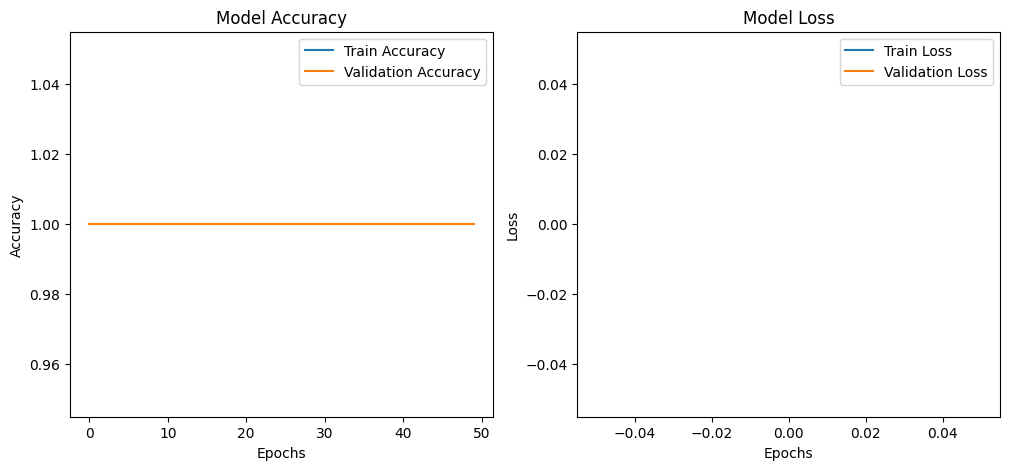

In [27]:
# Fetch stock data from Yahoo Finance
tickers = ["AAPL", "GOOGL", "MSFT", "TSLA"]
data = []

for ticker in tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")

    if hist.empty:
        print(f"Warning: No data available for {ticker}")
        continue

    info = stock.info

    # Extract financial ratios with better handling of missing values
    pe_ratio = info.get('forwardPE', np.nan)
    peg_ratio = info.get('PEG Ratio', np.nan)

    roe_ratio = info.get('returnOnEquity', None)
    roe_ratio = roe_ratio * 100 if roe_ratio is not None else np.nan  # Convert to percentage if available

    quick_ratio = info.get('quickRatio', np.nan)  # Some stocks may not have this

    eps = info.get('trailingEps', np.nan)
    volume = hist['Volume'].mean() if not hist['Volume'].isna().all() else np.nan
    moving_avg = hist['Close'].rolling(window=50).mean().iloc[-1] if len(hist) >= 50 else np.nan
    market_cap = info.get('marketCap', np.nan)
    rsi = calculate_rsi(hist['Close'])

    # Define investment-worthiness criteria
    investment_worthy = (
        pe_ratio < 25 and peg_ratio < 2 and
        roe_ratio > 5 and quick_ratio > 1.5
    )

    # Store data
    data.append({
        'PE_Ratio': pe_ratio,
        'PEG_Ratio': peg_ratio,
        'ROE_Ratio': roe_ratio,
        'Quick_Ratio': quick_ratio,
        'EPS': eps,
        'Volume': volume,
        'RSI': rsi,
        'Moving_Avg': moving_avg,
        'Market_Cap': market_cap,
        'Buy_Signal': int(investment_worthy)
    })

# Convert data to DataFrame
df = pd.DataFrame(data)

# Debugging: Print collected data to ensure it's not empty
print("Raw collected stock data:\n", df)

# Handle missing data by filling NaNs instead of dropping rows
df = df.fillna(df.median())  # Replace NaNs with median values instead of dropping

if df.empty:
    raise ValueError("No valid stock data available. Please check the ticker.")

# Define features and target
features = ['PE_Ratio', 'PEG_Ratio', 'ROE_Ratio', 'Quick_Ratio', 'EPS', 'Volume', 'RSI', 'Moving_Avg', 'Market_Cap']
target = 'Buy_Signal'
X = df[features].values
y = df[target].values

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build ANN model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save model
model.save("stock_screening_ann.h5")

# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [28]:
# ---- STOCK SCREENING ----
model = keras.models.load_model('stock_screening_ann.h5')
tickers = ["AAPL", "GOOGL", "MSFT"]
feature_data = []
visual_data = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1y")

    if hist.empty:
        print(f"Warning: No data available for {ticker}")
        continue

    info = stock.info
    pe_ratio = info.get('forwardPE', np.nan)
    peg_ratio = info.get('PEG_Ratio', np.nan)
    roe_ratio = info.get('returnOnEquity', np.nan) * 100 if info.get('returnOnEquity') else np.nan
    quick_ratio = info.get('quickRatio', np.nan)
    eps = info.get('trailingEps', np.nan)
    volume = hist['Volume'].mean() if not hist['Volume'].isna().all() else np.nan
    moving_avg = hist['Close'].rolling(window=50).mean().iloc[-1] if len(hist) >= 50 else np.nan
    market_cap = info.get('marketCap', np.nan)
    rsi = calculate_rsi(hist['Close'])

    visual_data[ticker] = {'PE_Ratio': pe_ratio, 'PEG_Ratio': peg_ratio, 'ROE_Ratio': roe_ratio, 'Quick_Ratio': quick_ratio,
                            'EPS': eps, 'Volume': volume, 'RSI': rsi, 'Moving_Avg': moving_avg, 'Market_Cap': market_cap}
    feature_data.append([pe_ratio, peg_ratio, roe_ratio, quick_ratio, eps, volume, rsi, moving_avg, market_cap])

feature_data = np.array(feature_data)
feature_data = scaler.transform(feature_data)
predictions = model.predict(feature_data).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


AAPL: Do Not Buy (Prediction: nan)
GOOGL: Do Not Buy (Prediction: nan)
MSFT: Do Not Buy (Prediction: nan)


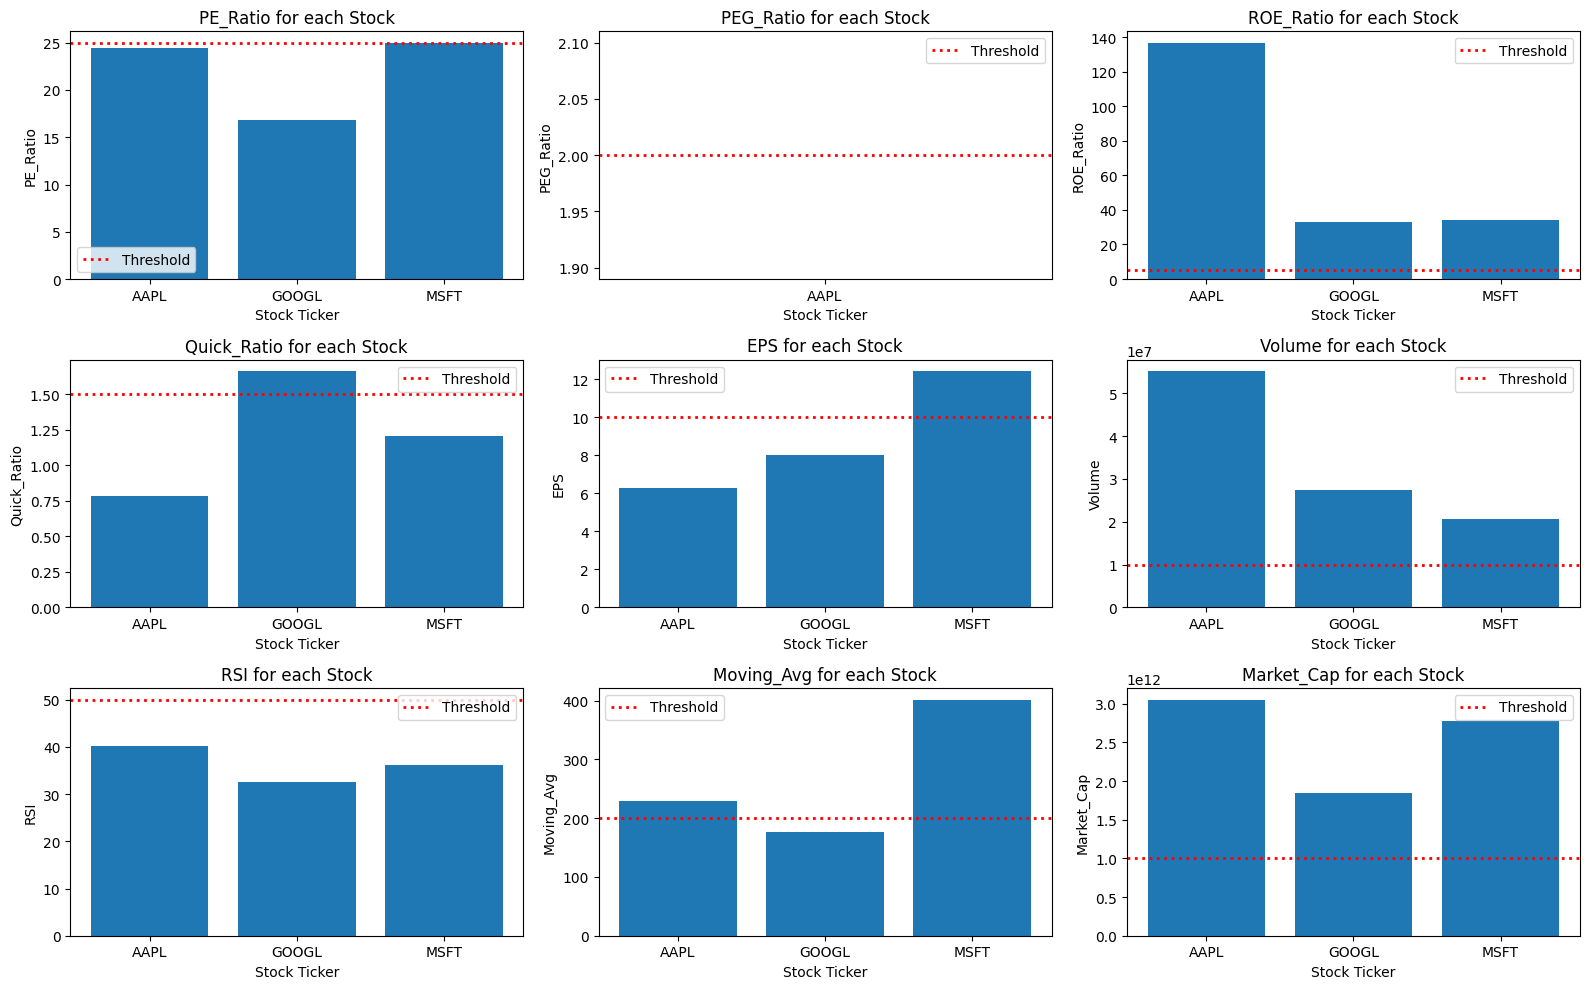

Consider investing if the following criteria is met:
PE Ratio should be less than 25
PEG Ratio should be less than 2
ROE Ratio should be greater than 5
Quick Ratio should be greater than 1.5
Current stock price is greater than the moving average
RSI is low


In [32]:



# Assuming `visual_data` is a dictionary containing stock data
# and `predictions` contains ANN predictions

for ticker, prediction in zip(visual_data.keys(), predictions):
    recommendation = "Buy" if prediction > 0.5 else "Do Not Buy"
    print(f"{ticker}: {recommendation} (Prediction: {prediction:.2f})")

fig, axes = plt.subplots(3, 3, figsize=(16, 10))  # 3x3 grid for features
feature_names = features  # List of feature names
axes = axes.flatten()

# Define threshold values for each feature (Example: Adjust as needed)
thresholds = {
    'PE_Ratio': 25,
    'PEG_Ratio': 2,
    'ROE_Ratio': 5,
    'Quick_Ratio': 1.5,
    'EPS': 10,
    'Volume': 1e7,
    'RSI': 50,
    'Moving_Avg': 200,
    'Market_Cap': 1e12
}

for i, feature in enumerate(feature_names):
    if i < len(axes):  # Ensure we don't exceed subplot limits
        ax = axes[i]
        values = [visual_data[ticker][feature] for ticker in visual_data.keys()]

        # Bar plot
        ax.bar(visual_data.keys(), values)
        ax.set_title(f"{feature} for each Stock")
        ax.set_ylabel(feature)
        ax.set_xlabel("Stock Ticker")

        # Add dotted threshold line if available
        if feature in thresholds:
            ax.axhline(y=thresholds[feature], color='red', linestyle='dotted', linewidth=2, label="Threshold")
            ax.legend()

    else:
        print(f"Warning: Skipping plot for feature '{feature}' due to insufficient subplot space.")

plt.tight_layout()
plt.show()

print("Consider investing if the following criteria is met:")
print("PE Ratio should be less than 25")
print("PEG Ratio should be less than 2")
print("ROE Ratio should be greater than 5")
print("Quick Ratio should be greater than 1.5")
print("Current stock price is greater than the moving average")
print("RSI is low")
